# QAOA 求解最大割问题

<em> Copyright (c) 2021 Institute for Quantum Computing, Baidu Inc. All Rights Reserved. </em>

## 概览

在[量子近似优化算法教程](./QAOA_CN.ipynb)中，我们介绍了如何将经典的组合优化问题编码为量子优化问题，并用量子近似优化算法 [1]（quantum approximate optimization algorithm, QAOA）求解。在本教程中，我们将以最大割问题为例来进一步阐述 QAOA。

### 最大割问题

最大割问题（Max-Cut Problem）是图论中常见的一个组合优化问题，在统计物理学和电路设计中都有重要应用。最大割问题是一个 NP 困难问题，因此目前并不存在一个高效的算法能完美地解决该问题。

在图论中，一个图是由一对集合 $G=(V, E)$ 表示，其中集合 $V$ 中的元素为该图的顶点，集合 $E$ 中的每个元素是一对顶点，表示连接这两个顶点的一条边。例如下方图片中的图可以由 $V=\{0,1,2,3\}$ 和 $E=\{(0,1),(1,2),(2,3),(3,0)\}$ 表示。

![G](figures/maxcut-fig-maxcut_g.png "图 1：一个有四个顶点和四条边的图")
<div style="text-align:center">图 1：一个有四个顶点和四条边的图 </div>


一个图上的割（cut）是指将该图的顶点集 $V$ 分割成两个互不相交的集合的一种划分，每个割都对应一个边的集合，这些边的两个顶点被划分在不同的集合中。于是我们可以将这个割的大小定义为这个边的集合的大小，即被割开的边的条数。最大割问题就是要找到一个割使得被割开的边的条数最多。图 2 展示了图 1 中图的一个最大割，该最大割的大小为 $4$，即割开了图中所有的边。

![Max cut on G](figures/maxcut-fig-maxcut_cut.png "图 2：图 1 中图的一个最大割")
<div style="text-align:center">图 2：图 1 中图的一个最大割 </div>


假设输入的图 $G=(V, E)$ 有 $n=|V|$ 个顶点和 $m=|E|$ 条边，那么我们可以将最大割问题描述为 $n$ 个比特和 $m$ 个子句的组合优化问题。每个比特对应图 $G$ 中的一个顶点 $v$，其取值 $z_v$ 为 $0$ 或 $1$，分别对应该顶点属于集合 $S_{0}$ 或 $S_{1}$，因此这 $n$ 个比特的每种取值 $z$ 都对应一个割。每个子句则对应图 $G$ 中的一条边 $(u,v)$，一个子句要求其对应的边连接的两个顶点的取值不同，即 $z_u\neq z_v$，表示该条边被割开。也就是说，当该条边连接这的两个顶点被割划分到不同的集合上时，我们说该子句被满足。因此，对于图 $G$ 中的每条边 $(u,v)$，我们有

$$
C_{(u,v)}(z) = z_u+z_v-2z_uz_v,
\tag{1}
$$

其中 $C_{(u,v)}(z) = 1$ 当且仅当该条边被割开。否则，该函数等于 $0$。整个组合优化问题的目标函数是

$$
C(z) = \sum_{(u,v)\in E}C_{(u,v)}(z) = \sum_{(u,v)\in E}z_u+z_v-2z_uz_v.
\tag{2}
$$

因此，解决最大割问题就是要找到一个取值 $z$ 使得公式（2）中的目标函数最大。

### 编码最大割问题

为了将最大割问题转化为一个量子问题，我们要用到 $n$ 个量子比特，每个量子比特对应图 $G$ 中的一个顶点。一个量子比特处于量子态 $|0\rangle$ 或 $|1\rangle$，表示其对应的顶点属于集合 $S_{0}$ 或 $S_{1}$。值得注意的是，$|0\rangle$ 和 $|1\rangle$ 是 Pauli $Z$ 门的两个本征态，并且它们的本征值分别为 $1$ 和 $-1$，即

$$
\begin{align}
Z|0\rangle&=|0\rangle,\tag{3}\\
Z|1\rangle&=-|1\rangle.\tag{4}
\end{align}
$$

因此我们可以使用 Pauli $Z$ 门来构建该最大割问题的哈密顿量 $H_C$。因为通过映射 $f(x):x\to(x+1)/2$ 可以将 $-1$ 映射到 $0$ 上 并且仍将 $1$ 映射到 $1$ 上，所以我们可以将式（2）中的 $z$ 替换为 $(Z+I)/2$（$I$ 是单位矩阵），得到原问题目标函数对应的哈密顿量

$$
\begin{align}
H_C &= \sum_{(u,v)\in E} \frac{Z_u+I}{2} + \frac{Z_v+I}{2} - 2\cdot\frac{Z_u+I}{2}\frac{Z_v+I}{2}\tag{5}\\
&= \sum_{(u,v)\in E} \frac{Z_u+Z_v+2I - (Z_uZ_v+Z_u+Z_v+I)}{2}\tag{6}\\
&= \sum_{(u,v)\in E} \frac{I - Z_uZ_v}{2}.\tag{7}
\end{align}
$$

该哈密顿量关于一个量子态 $|\psi\rangle$ 的期望值为

$$
\begin{align}
\langle\psi|H_C|\psi\rangle &= \langle\psi|\sum_{(u,v)\in E} \frac{I - Z_uZ_v}{2}|\psi\rangle\tag{8}\\
&= \langle\psi|\sum_{(u,v)\in E} \frac{I}{2}|\psi\rangle - \langle\psi|\sum_{(u,v)\in E} \frac{Z_uZ_v}{2}|\psi\rangle\tag{9}\\
&= \frac{|E|}{2} - \frac{1}{2}\langle\psi|\sum_{(u,v)\in E} Z_uZ_v|\psi\rangle.\tag{10}
\end{align}
$$

如果我们记

$$
H_D = -\sum_{(u,v)\in E} Z_uZ_v,
\tag{11}
$$

那么找到量子态 $|\psi\rangle$ 使得 $\langle\psi|H_C|\psi\rangle$ 最大等价于找到量子态 $|\psi\rangle$ 使得 $\langle\psi|H_D|\psi\rangle$ 最大。

## Paddle Quantum 实现

接下来，我们用量桨实现 QAOA 来求解最大割问题。有许多方法可以找到参数 $\vec{\gamma},\vec{\beta}$，我们这里使用经典机器学习中的梯度下降方法。

要在量桨上实现 QAOA，首先要做的便是加载需要用到的包。其中 `networkx` 包可以帮助我们方便地处理图。

In [1]:
from IPython.core.display import HTML
display(HTML("<style>pre { white-space: pre !important; }</style>"))

In [16]:
# 加载量桨、飞桨的相关模块
import paddle
from paddle_quantum.ansatz import Circuit
from paddle_quantum.qinfo import pauli_str_to_matrix
from paddle_quantum.loss import ExpecVal
from paddle_quantum import Hamiltonian

# 加载额外需要用到的包
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

import warnings
warnings.filterwarnings("ignore")

接下来，我们生成该最大割问题中的图 $G$。为了运算方便，这里的顶点从 $0$ 开始计数。

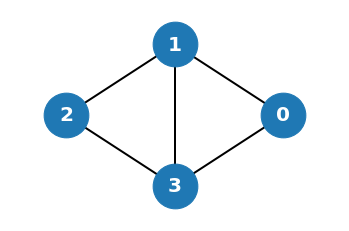

In [3]:
# n 是图 G 的顶点数，同时也是量子比特的个数
n = 4
G = nx.Graph()
V = range(n)
G.add_nodes_from(V)
E = [(0, 1), (1, 2), (2, 3), (3, 0), (1, 3)]
G.add_edges_from(E)

# 将生成的图 G 打印出来
pos = nx.circular_layout(G)
options = {
    "with_labels": True,
    "font_size": 20,
    "font_weight": "bold",
    "font_color": "white",
    "node_size": 2000,
    "width": 2
}
nx.draw_networkx(G, pos, **options)
ax = plt.gca()
ax.margins(0.20)
plt.axis("off")
plt.show()

### 编码哈密顿量

量桨中，哈密顿量可以以 `list` 的形式输入。这里我们构建式（11）中的哈密顿量 $H_D$。

In [4]:
# 以 list 的形式构建哈密顿量 H_D
H_D_list = []
for (u, v) in E:
    H_D_list.append([-1.0, 'z'+str(u) + ',z' + str(v)])
print(H_D_list)

[[-1.0, 'z0,z1'], [-1.0, 'z1,z2'], [-1.0, 'z2,z3'], [-1.0, 'z3,z0'], [-1.0, 'z1,z3']]


可以看到，在这个例子中，哈密顿量 $H_D$ 为

$$
H_D = -Z_0Z_1 - Z_1Z_2 - Z_2Z_3 - Z_3Z_0.
\tag{12}
$$

我们可以查看哈密顿量 $H_D$ 的矩阵形式，并且获取它的本征值信息：

In [5]:
# 将哈密顿量 H_D 从 list 形式转为矩阵形式
H_D_matrix = pauli_str_to_matrix(H_D_list, n)
# 取出 H_D 对角线上的元素
H_D_diag = np.diag(H_D_matrix).real
# 获取 H_D 的最大本征值
H_max = np.max(H_D_diag)

print(H_D_diag)
print('H_max:', H_max)

[-5.  1. -1.  1.  1.  3.  1. -1. -1.  1.  3.  1.  1. -1.  1. -5.]
H_max: 3.0


### 搭建 QAOA 电路

前面我们介绍了 QAOA 需要将两个酉变换 $U_C(\gamma)$ 和 $U_B(\beta)$ 交替地作用在初始态 $|s\rangle = |+\rangle^{\otimes n}$ 上。在这里，我们使用量桨中提供的量子门和量子电路模板搭建出一个量子电路来实现这一步骤。要注意的是，在最大割问题中，我们将最大化哈密顿量 $H_C$ 的期望值的问题简化为了最大化哈密顿量 $H_D$ 的期望值的问题，因此要用到的酉变换也就变成了 $U_D(\gamma)$ 和 $U_B(\beta)$。通过交替地摆放两个参数可调的电路模块，我们得以搭建QAOA电路

$$
U_B(\beta_p)U_D(\gamma_p)\cdots U_B(\beta_1)U_D(\gamma_1),
\tag{13}
$$

其中，$U_D(\gamma) = e^{-i\gamma H_D}$ 可以由下图中的电路搭建实现。另一个酉变换 $U_B(\beta)$ 则等价于在每个量子比特上作用一个 $R_x$ 门。

![U_D circuit](figures/maxcut-fig-cir_ud.png "图 3：酉变换 $e^{i\gamma Z\otimes Z}$ 的量子电路实现")
<div style="text-align:center">图 3：酉变换 $e^{i\gamma Z\otimes Z}$ 的量子电路实现 </div>


因此，实现一层酉变换 $U_B(\beta)U_D(\gamma)$ 的量子电路如图 4 所示。

![U_BU_D circuit](figures/maxcut-fig-cir_ubud.png "图 4：酉变换 $U_B(\beta)U_D(\gamma)$ 的量子电路实现")
<div style="text-align:center">图 4：酉变换 $U_B(\beta)U_D(\gamma)$ 的量子电路实现 </div>

量桨中，电路运行前每个量子比特默认的初始状态为 $|0\rangle$（可以通过输入参数来自定义初始状态），我们可以通过添加一层 Hadamard 门使每个量子比特的状态由 $|0\rangle$ 变为 $|+\rangle$，由此得到 QAOA 要求的初始态 $|s\rangle = |+\rangle^{\otimes n}$。在量桨中，可以通过调用 `superposition_layer()` 在量子电路中添加一层 Hadamard 门。

In [6]:
def circuit_QAOA(p):
    # 初始化 n 个量子比特的量子电路
    cir = Circuit(n)
    # 制备量子态 |s>
    cir.superposition_layer()
    # 搭建p层U_D电路
    cir.qaoa_layer(E,V,p)
    
    return cir


搭建 QAOA 量子电路的工作完成后，如果运行该量子电路，得到的输出态为

$$
|\vec{\gamma},\vec{\beta}\rangle = U_B(\beta_p)U_D(\gamma_p)\cdots U_B(\beta_1)U_D(\gamma_1)|s\rangle.
\tag{14}
$$

### 计算损失函数

由上一步搭建的电路的输出态，我们可以计算最大割问题的目标函数

$$
F_p(\vec{\gamma},\vec{\beta}) = \langle\vec{\gamma},\vec{\beta}|H_D|\vec{\gamma},\vec{\beta}\rangle.
\tag{15}
$$

要最大化该目标函数等价于最小化 $-F_p$。因此我们定义 $L(\vec{\gamma},\vec{\beta}) = -F_p(\vec{\gamma},\vec{\beta})$ 为损失函数，即要最小化的函数，然后利用经典的优化算法寻找最优参数 $\vec{\gamma},\vec{\beta}$。下面的代码给出了通过量桨构造的损失函数：

In [7]:
# 构造损失函数
loss_func = ExpecVal(Hamiltonian(H_D_list))

### 训练量子神经网络
定义好了用于 QAOA 的量子神经网络后，我们使用梯度下降的方法来更新其中的参数，使得式（15）的期望值最大。

In [8]:
p = 4      # 量子电路的层数
ITR = 120  # 训练迭代的次数
LR = 0.1   # 基于梯度下降的优化方法的学习率
SEED = 1024 #设置全局随机数种子

这里，我们在飞桨中优化上面定义的损失函数。

In [17]:
paddle.seed(SEED)

cir = circuit_QAOA(p)
# 使用 Adam 优化器
opt = paddle.optimizer.Adam(learning_rate=LR, parameters=cir.parameters())

for itr in range(1, ITR + 1):
    state = cir()
    # 计算梯度并优化
    loss = -loss_func(state)
    loss.backward()
    opt.minimize(loss)
    opt.clear_grad()
    if itr % 10 == 0:
        print("iter:", itr, "  loss:", "%.4f" % loss.numpy())


iter: 10   loss: -1.8359
iter: 20   loss: -2.5392
iter: 30   loss: -2.7250
iter: 40   loss: -2.8061
iter: 50   loss: -2.8748
iter: 60   loss: -2.9134
iter: 70   loss: -2.9302
iter: 80   loss: -2.9321
iter: 90   loss: -2.9321
iter: 100   loss: -2.9325
iter: 110   loss: -2.9327
iter: 120   loss: -2.9328


### 解码量子答案
当求得损失函数的最小值以及相对应的一组参数 $\vec{\gamma}^*,\vec{\beta}^*$ 后，我们的任务还没有完成。为了进一步求得 Max-Cut 问题的近似解，需要从 QAOA 输出的量子态 $|\vec{\gamma}^*,\vec{\beta}^*\rangle$ 中解码出经典优化问题的答案。物理上，解码量子态需要对量子态进行测量，然后统计测量结果的概率分布：

$$
p(z)=|\langle z|\vec{\gamma}^*,\vec{\beta}^*\rangle|^2.
\tag{16}
$$

通常情况下，某个比特串出现的概率越大，意味着其对应 Max-Cut 问题最优解的可能性越大。

Paddle Quantum 提供了查看 QAOA 量子电路输出状态的测量结果概率分布的函数：

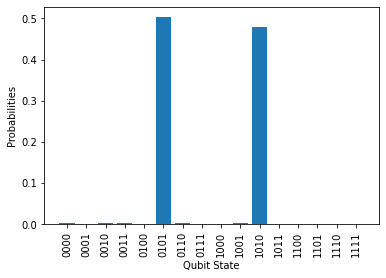

In [14]:
state = cir()
# 模拟重复测量电路输出态 1024 次
prob_measure = state.measure(shots=1024, plot=True)

通过测量，找到出现几率最高的比特串。 此时，记其在该比特串中对应的比特取值为 $0$ 的顶点属于集合 $S_0$ 以及对应比特取值为 $1$ 的顶点属于集合 $S_1$，这两个顶点集合之间存在的边就是该图的一个可能的最大割方案。

下面的代码选取测量结果中出现几率最大的比特串，然后将其映射回经典解，并且画出对应的最大割方案：
- 红色顶点属于集合 $S_0$，
- 蓝色顶点属于集合 $S_1$，
- 虚线表示被割的边。

找到的割的比特串形式： 0101


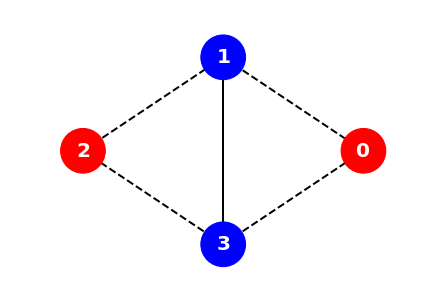

In [15]:
# 找到测量结果中出现几率最大的比特串
cut_bitstring = max(prob_measure, key=prob_measure.get)
print("找到的割的比特串形式：", cut_bitstring)

# 在图上画出上面得到的比特串对应的割
node_cut = ["blue" if cut_bitstring[v] == "1" else "red" for v in V]

edge_cut = []
for u in range(n):
    for v in range(u+1,n):
        if (u, v) in E or (v, u) in E:
            if cut_bitstring[u] == cut_bitstring[v]:
                edge_cut.append("solid")
            else:
                edge_cut.append("dashed")

nx.draw(
        G,
        pos,
        node_color=node_cut,
        style=edge_cut,
        **options
)
ax = plt.gca()
ax.margins(0.20)
plt.axis("off")
plt.show()

可以看到，在这个例子中 QAOA 找到了图上的一个最大割。

_______

## 参考文献

[1] Farhi, E., Goldstone, J. & Gutmann, S. A Quantum Approximate Optimization Algorithm. [arXiv:1411.4028 (2014).](https://arxiv.org/abs/1411.4028)